In [1]:
import os 
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
import numpy as np
import nltk
import re
from wordcloud import WordCloud

In [2]:
nodes = pd.read_csv('/home/manoj/tuhh/data_science_3rd_sem/deep_learning_for_social_analytics/project/deep-learning-for-social-analytics-project/cleaned_datasets/nodes.csv')


In [3]:
nodes.dtypes


spotify_id     object
name           object
followers     float64
popularity      int64
genres         object
chart_hits     object
dtype: object

In [4]:
nodes.isnull().sum()

spotify_id         0
name               4
followers          4
popularity         0
genres             0
chart_hits    136781
dtype: int64

In [5]:
nodes.dropna(subset=['name'], inplace=True)
#delete null names as they are not required.


In [6]:
nodes.dropna(subset=['followers'], inplace=True)
#delete null followers

In [7]:

from concurrent.futures import ProcessPoolExecutor
from langdetect import detect, DetectorFactory

# Ensure consistent results from langdetect
DetectorFactory.seed = 0

def is_english(text):
    try:
        # Fast ASCII check to quickly determine if a text is likely English
        if all(ord(char) < 128 for char in text):
            return True
        return detect(text) == 'en'
    except:
        return False

def filter_english_on_name(df):
    with ProcessPoolExecutor() as executor:
        # Mapping the language detection function to the 'name' column only as spotify_id has some ids
        name_english = list(executor.map(is_english, df['name']))
    # return the english name    
    return df[name_english]

nodes_english = filter_english_on_name(nodes)

# Print or further process the filtered DataFrame
print(nodes_english)

                    spotify_id                name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2       652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3       3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4       74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   
...                        ...                 ...        ...         ...   
156417  2ces6d2YsQP1RpGMYpdFy8        David Urwitz     5470.0          29   
156418  6AeznZajNbXUulT7W4tK5l             Darmiko     2022.0          23   
156419  3GEijIjrgb4lPe9WtURBzz            Katriell      268.0           0   
156420  0ldQL0icSoMz9OOZcWG8Zt          Yung Fresh      181.0          19   
156421  1QZqarAGs0Lxx495oNcBnZ       Rakshitha Rao       23.0          24   

                                                   genres  \
0             

In [8]:
nodes_english.shape

(143848, 6)

In [9]:
nodes_english = nodes_english.drop(columns=['chart_hits'])

In [10]:
nodes_english.shape

(143848, 5)

In [11]:
nodes_english.describe()

,followers,popularity
count,1.438480e+05,143848.000000
mean,8.837959e+04,21.444845
std,9.666695e+05,18.384521
min,0.000000e+00,0.000000
25%,2.600000e+01,4.000000
50%,3.910000e+02,19.000000
75%,6.551000e+03,35.000000
max,1.021569e+08,100.000000


In [12]:

# This is to know the unique genres.
import pandas as pd
import ast


# Convert genre strings to lists
nodes_english['genre_list'] = nodes_english['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Collect all unique genres
unique_genres = set(genre for sublist in nodes_english['genre_list'] for genre in sublist)

# Print the unique genres
print("Unique genres:")
for genre in unique_genres:
    print(genre)

Unique genres:
bornesange
bomba
folklore nuevo argentino
string band
uplifting trance
microhouse
classic russian rock
swedish indie folk
chip hop
alternative rock
outlaw country
rock chapin
zamba
laboratorio
washboard
pop violin
euroska
virginia metal
minneapolis sound
hip hop boliviano
orchestra
lithuanian indie
cardiff indie
oratory
musica mocambicana
deep dance pop
australian classical
cumbia villera
liechtenstein
french indie folk
pop minang
alt-idol
funeral doom
country quebecois
brazilian hardcore
louvor
tropical alternativo
italian post punk
world devotional
tuareg guitar
naat
turkce kadin rap
vallenato
ottawa indie
pittsburgh indie
glitchbreak
rare groove
modern big band
german black metal
drone rock
fnaf
doomcore
uk funky
zouglou
kleine hoerspiel
pittsburgh rock
baton rouge rap
dutch dnb
japanese edm
polish modern jazz
korean ost
finnish metal
syrian hip hop
azeri rap
math pop
electro swing
post-doom metal
narodnozabavna
kazakh hip hop
quebec indie
deep big room
plug brasileir

In [21]:
import pandas as pd
import ast
import re


# Convert genre strings to lists
nodes_english['genre_list'] = nodes_english['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Collect all unique genres
unique_genres = set(genre for sublist in nodes_english['genre_list'] for genre in sublist)

# Define the mapping from sub-genres to prominent genres
top_genres = {
    'pop': ['pop', 'j-pop', 'k-pop', 'synthpop', 'electropop', 'teen pop'],
    'rock': ['rock', 'punk', 'garage'],
    'hip_hop': ['hip hop', 'rap', 'drill'],
    'electronic': ['edm', 'house', 'techno', 'electronic', 'trance', 'dance'],
    'jazz': ['jazz'],
    'folk world': ['folk', 'celtic', 'world', 'americana', 'country'],
    'randb_Soul': ['soul', 'r&b', 'rhythm and blues', 'funk', 'blues'],
    'metal': ['metal'],
    'classical_orchestral': ['classical', 'orchestral', 'symphony'],
    'reggae_dancehall': ['reggae', 'dub', 'riddim', 'ska'],
    'latin': ['salsa', 'latin', 'bachata', 'cumbia'],
    'alternative Indie': ['indie', 'alternative', 'emo'],
    'blues': ['blues'],
    'punk': ['punk'],
    'soundtrack': ['soundtrack', 'anime', 'broadway', 'movie']
}

# Function to assign each unique genre to a top genre
def assign_genre(unique_genre):
    # Clean up the genre string for matching
    genre_clean = unique_genre.lower().strip()
    
    # Check against each top genre's sub-genres
    for top_genre, subgenres in top_genres.items():
        for subgenre in subgenres:
            # Use regex to check for word boundaries to avoid partial matches
            if re.search(rf'\b{subgenre}\b', genre_clean):
                return top_genre
    return 'unknown'

# Map each unique genre to a top genre
genre_mapping = {genre: assign_genre(genre) for genre in unique_genres}

# Apply this mapping to a column in your DataFrame
nodes_english['prominent_genres'] = nodes_english['genre_list'].apply(
    lambda genres: [genre_mapping.get(genre, 'Other') for genre in genres]
)

# You can now view the resultant DataFrame to check the mappings
print(nodes_english[['genres', 'prominent_genres']])

                                                   genres  \
0                          ['nordic house', 'russelater']   
1                  ['christlicher rap', 'german hip hop']   
2                                                      []   
3       ['dancehall', 'lovers rock', 'modern reggae', ...   
4       ['classic swedish pop', 'norrbotten indie', 's...   
...                                                   ...   
156417                            ['classic swedish pop']   
156418                                                 []   
156419                                                 []   
156420                                                 []   
156421                                                 []   

                                         prominent_genres  
0                                   [electronic, unknown]  
1                                      [hip_hop, hip_hop]  
2                                                      []  
3       [unknown, rock, reg

In [22]:

unique_prominent_genres = set(gen for sublist in nodes_english['prominent_genres'] for gen in sublist)

# Count the number of unique prominent genres
unique_count = len(unique_prominent_genres)

# Print the count and the unique prominent genres
print(f"Number of unique prominent genres: {unique_count}")
print("Unique prominent genres:", unique_prominent_genres)

Number of unique prominent genres: 14
Unique prominent genres: {'metal', 'rock', 'pop', 'classical_orchestral', 'unknown', 'electronic', 'hip_hop', 'alternative Indie', 'soundtrack', 'folk world', 'hazz', 'latin', 'reggae_dancehall', 'randb_Soul'}


In [23]:
# Step 1: Explode the genre lists into separate rows
df_exploded = nodes_english.explode('prominent_genres')

# Step 2: Ensure deduplication across these exploded items per original entry
df_exploded = df_exploded.groupby(df_exploded.index).apply(lambda x: x.drop_duplicates(subset=['prominent_genres'])).reset_index(level=0, drop=True)

# Step 3: Perform one-hot encoding
one_hot_encoded = pd.get_dummies(df_exploded['prominent_genres'])

# Step 4: Sum up genre indicators for each original record by grouping back using the initial index
final_one_hot_encoded = one_hot_encoded.groupby(one_hot_encoded.index).sum()

# Combine back to original DataFrame as needed
df_final = pd.concat([nodes_english.drop(columns=['prominent_genres']), final_one_hot_encoded], axis=1)

# Display the one-hot encoded result
print(df_final)

                    spotify_id                name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2       652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3       3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4       74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   
...                        ...                 ...        ...         ...   
156417  2ces6d2YsQP1RpGMYpdFy8        David Urwitz     5470.0          29   
156418  6AeznZajNbXUulT7W4tK5l             Darmiko     2022.0          23   
156419  3GEijIjrgb4lPe9WtURBzz            Katriell      268.0           0   
156420  0ldQL0icSoMz9OOZcWG8Zt          Yung Fresh      181.0          19   
156421  1QZqarAGs0Lxx495oNcBnZ       Rakshitha Rao       23.0          24   

                                                   genres  \
0             

In [24]:
df_final = df_final.drop(columns=['genres','genre_list'])


In [29]:
df_final.to_csv('artist_without_country_wise_rank.csv', index=False)

In [60]:
df = pd.read_csv('artist_without_country_wise_rank.csv')

In [61]:
df.shape

(143848, 18)

In [62]:
df.describe()

,followers,popularity,alternative Indie,classical_orchestral,electronic,folk world,hazz,hip_hop,latin,metal,pop,randb_Soul,reggae_dancehall,rock,soundtrack,unknown
count,1.438480e+05,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000
mean,8.837959e+04,21.444845,0.018825,0.008057,0.037275,0.009169,0.006695,0.079508,0.005923,0.002280,0.109484,0.023601,0.006264,0.026438,0.002412,0.162880
std,9.666695e+05,18.384521,0.135909,0.089399,0.189437,0.095317,0.081546,0.270530,0.076733,0.047697,0.312246,0.151804,0.078895,0.160433,0.049056,0.369258
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.600000e+01,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.910000e+02,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.551000e+03,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.021569e+08,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
df.isnull().sum()

spotify_id              0
name                    0
followers               0
popularity              0
alternative Indie       0
classical_orchestral    0
electronic              0
folk world              0
hazz                    0
hip_hop                 0
latin                   0
metal                   0
pop                     0
randb_Soul              0
reggae_dancehall        0
rock                    0
soundtrack              0
unknown                 0
dtype: int64

In [64]:
df.head(5)

,spotify_id,name,followers,popularity,alternative Indie,classical_orchestral,electronic,folk world,hazz,hip_hop,latin,metal,pop,randb_Soul,reggae_dancehall,rock,soundtrack,unknown
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [65]:
df.describe()

,followers,popularity,alternative Indie,classical_orchestral,electronic,folk world,hazz,hip_hop,latin,metal,pop,randb_Soul,reggae_dancehall,rock,soundtrack,unknown
count,1.438480e+05,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000,143848.000000
mean,8.837959e+04,21.444845,0.018825,0.008057,0.037275,0.009169,0.006695,0.079508,0.005923,0.002280,0.109484,0.023601,0.006264,0.026438,0.002412,0.162880
std,9.666695e+05,18.384521,0.135909,0.089399,0.189437,0.095317,0.081546,0.270530,0.076733,0.047697,0.312246,0.151804,0.078895,0.160433,0.049056,0.369258
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.600000e+01,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.910000e+02,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.551000e+03,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.021569e+08,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/tmp/ipykernel_9128/1168389460.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


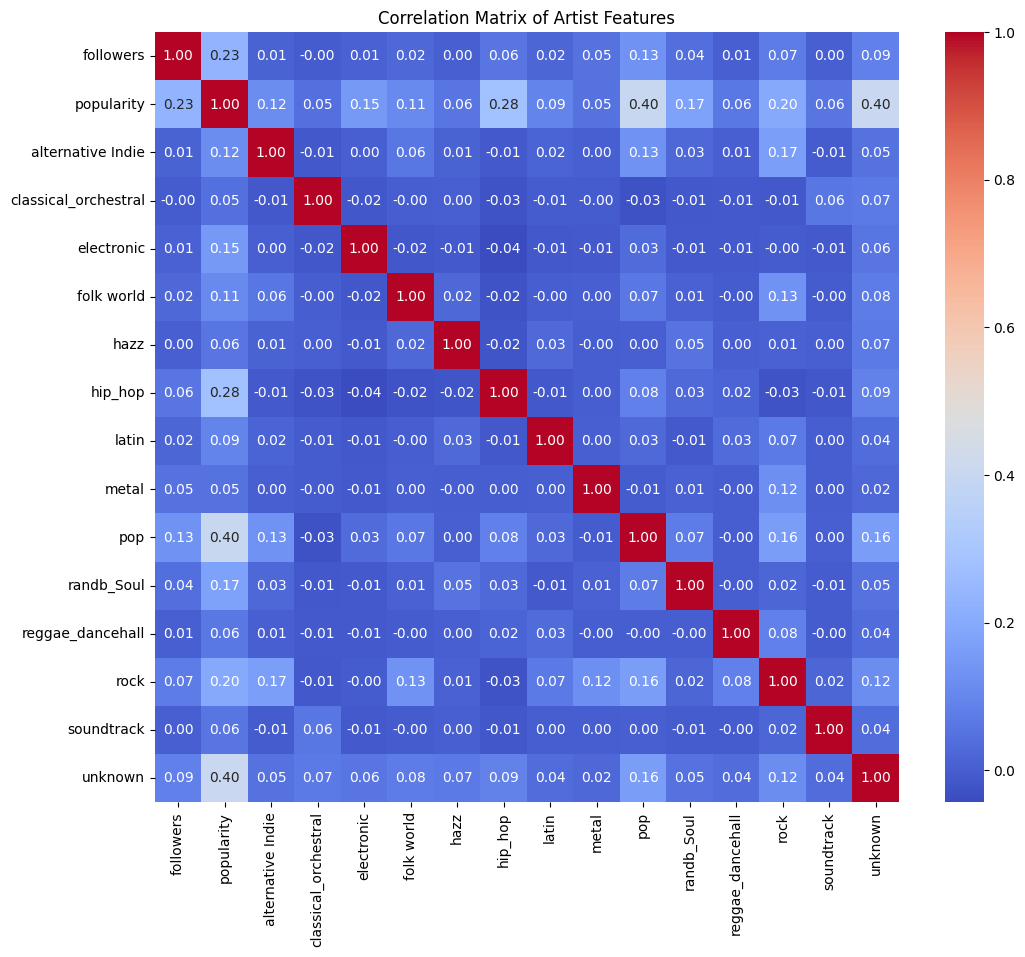

In [66]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Artist Features')
plt.show()

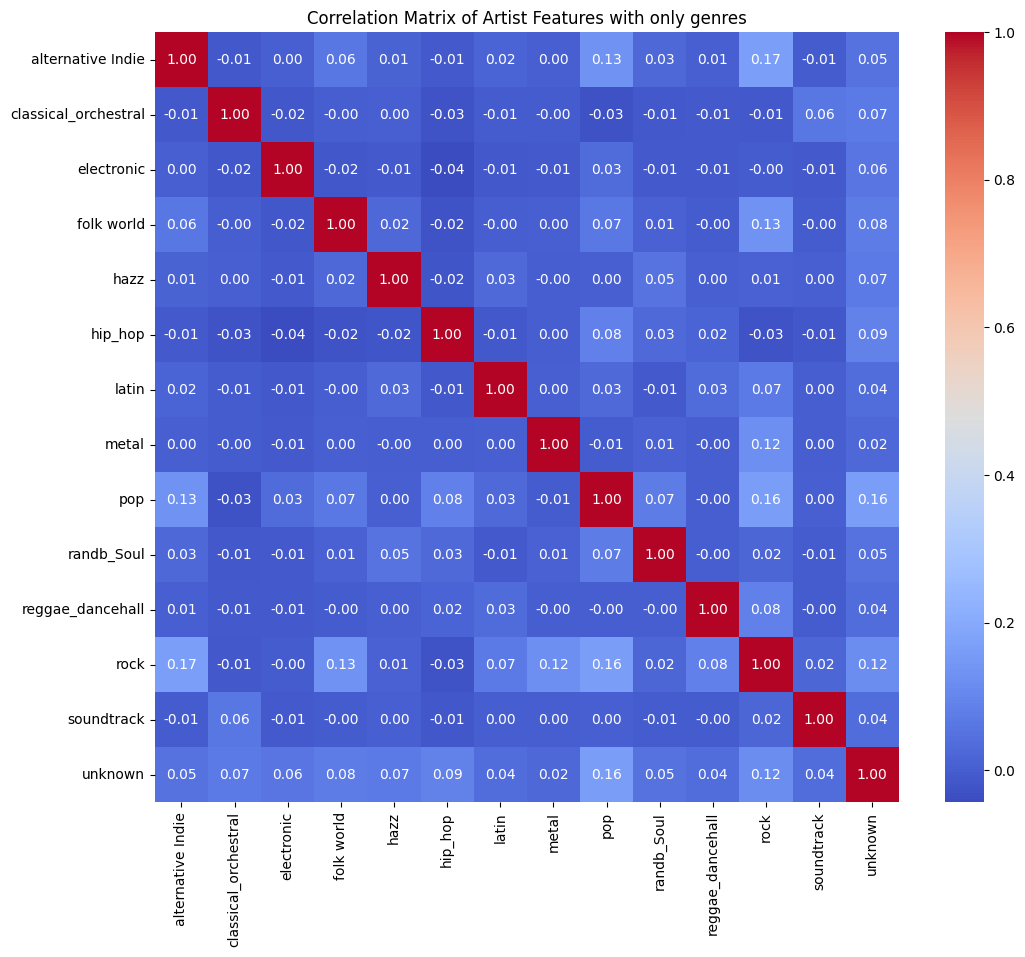

In [56]:
genres_columns= ['alternative Indie', 'classical_orchestral',
                      'electronic', 'folk world', 'hazz', 'hip_hop', 'latin', 'metal', 
                      'pop', 'randb_Soul', 'reggae_dancehall', 'rock', 'soundtrack', 'unknown']
correlation_matrix = df[genres_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Artist Features with only genres')
plt.show()

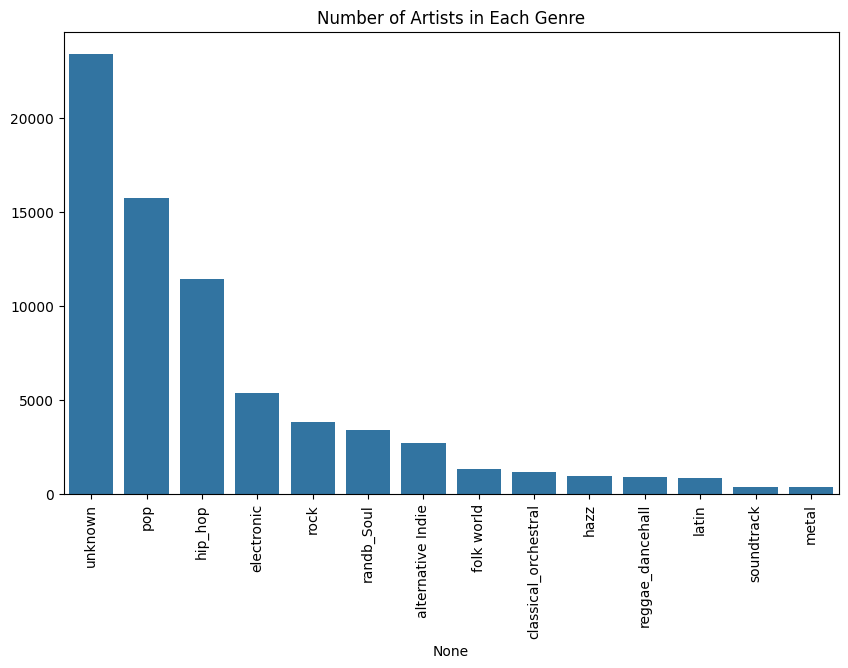

In [74]:
#columns after 'followers' and 'popularity'
genre_columns = columns_to_include[2:] 

# Sum of occurrences for each genre
genre_counts = df[genre_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Number of Artists in Each Genre')
plt.xticks(rotation=90)
plt.show()

In [75]:

print(df[['followers', 'popularity']].head(5))

   followers  popularity
0     1738.0          24
1  1999676.0          72
2    34596.0          36
3   249233.0          52
4    21193.0          39


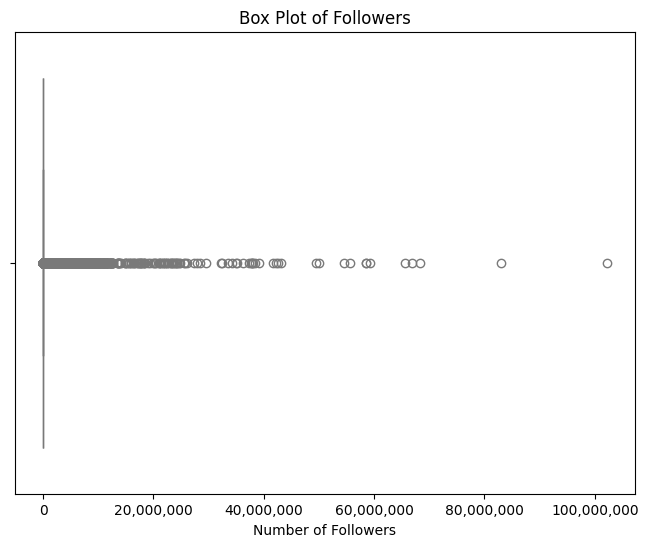

In [84]:
# plotting the distribution for the followers.
import matplotlib.ticker as ticker 


plt.figure(figsize=(8, 6))
sns.boxplot(x=df['followers'], color='lightblue')
plt.title('Box Plot of Followers')
plt.xlabel('Number of Followers')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

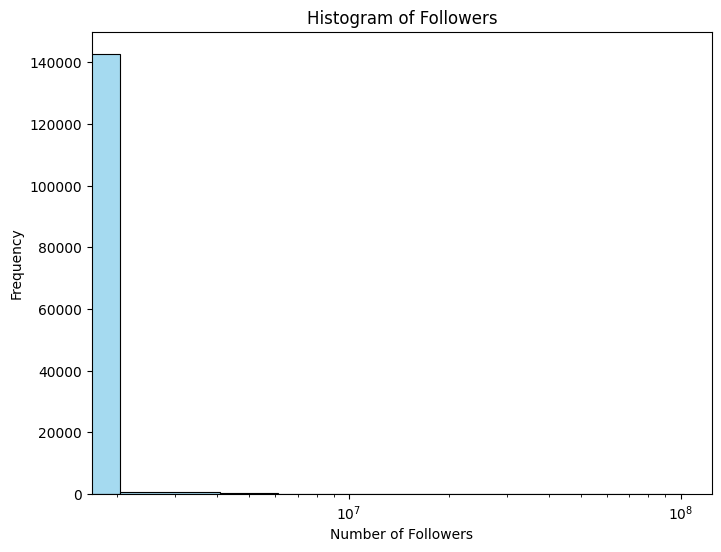

In [88]:

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['followers'], bins=50, kde=False, color='skyblue')
plt.title('Histogram of Followers')
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')

plt.xscale('log')

plt.show()

In [94]:
artists_above_20m = df[df['followers'] > 20000000]

# Count the number of such artists
count_artists_above_20m = len(artists_above_20m)
print(f"Number of artists with more than 20 million followers: {count_artists_above_20m}")

Number of artists with more than 20 million followers: 62


/tmp/ipykernel_9128/2386233236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artists_above_20m['name'], y=artists_above_20m['followers'], palette='viridis')


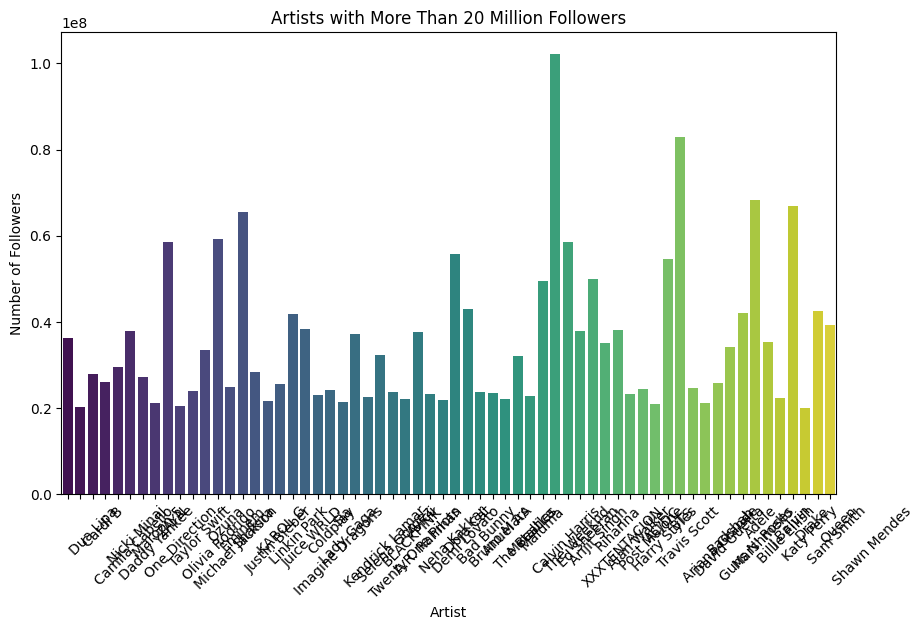

In [96]:

# Visualize the artists with more than 20 million followers
plt.figure(figsize=(10, 6))
sns.barplot(x=artists_above_20m['name'], y=artists_above_20m['followers'], palette='viridis')
plt.title('Artists with More Than 20 Million Followers')
plt.xlabel('Artist')
plt.ylabel('Number of Followers')
plt.xticks(rotation=45, ha='left')
plt.show()

/tmp/ipykernel_9128/2621168128.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artists_above_100m['name'], y=artists_above_100m['followers'], palette='viridis')


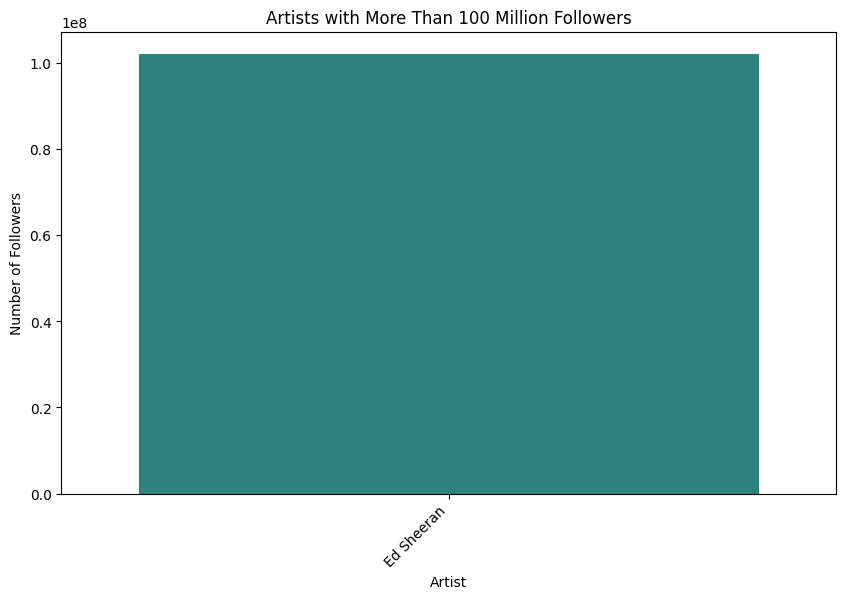

In [100]:
artists_above_100m = df[df['followers'] > 100000000]
plt.figure(figsize=(10, 6))
sns.barplot(x=artists_above_100m['name'], y=artists_above_100m['followers'], palette='viridis')
plt.title('Artists with More Than 100 Million Followers')
plt.xlabel('Artist')
plt.ylabel('Number of Followers')
plt.xticks(rotation=45, ha='right')
plt.show()

/tmp/ipykernel_9128/3623717970.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artists_above_60m['name'], y=artists_above_60m['followers'], palette='viridis')


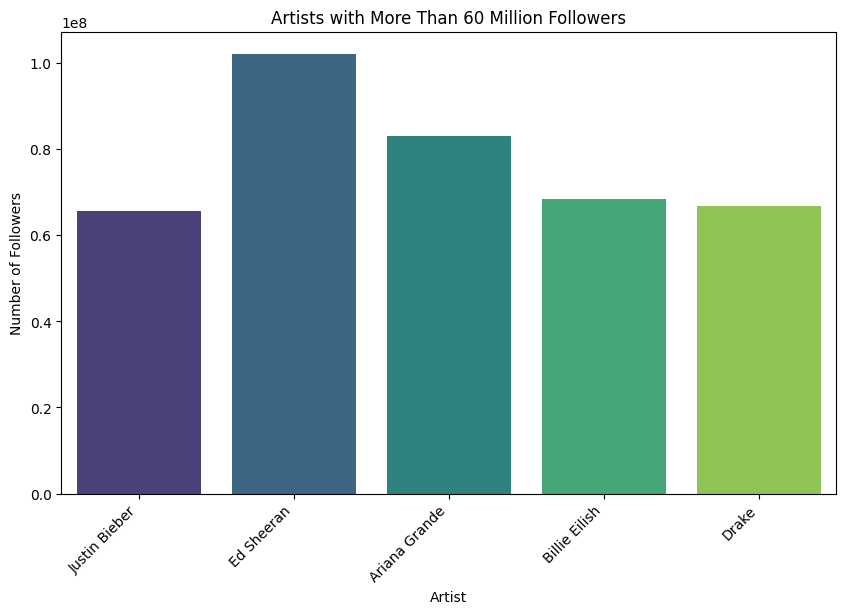

In [105]:
artists_above_60m = df[df['followers'] > 60000000]
plt.figure(figsize=(10, 6))
sns.barplot(x=artists_above_60m['name'], y=artists_above_60m['followers'], palette='viridis')
plt.title('Artists with More Than 60 Million Followers')
plt.xlabel('Artist')
plt.ylabel('Number of Followers')
plt.xticks(rotation=45, ha='right')
plt.show()

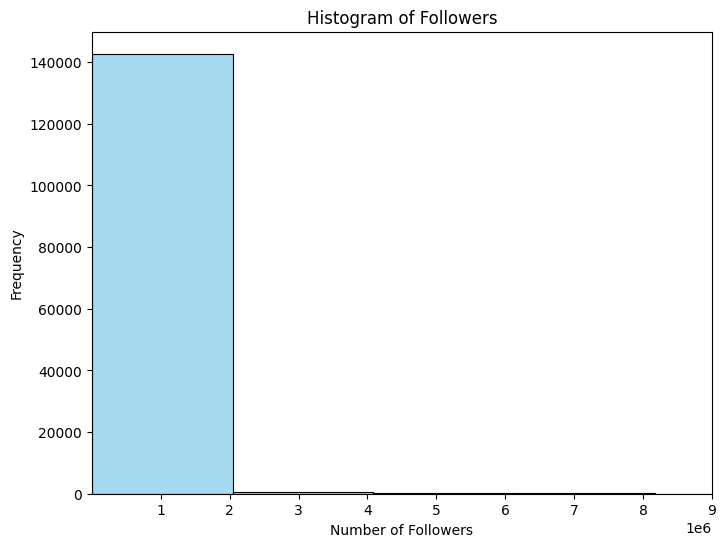

In [106]:

plt.figure(figsize=(8, 6))
sns.histplot(df['followers'], bins=50, kde=False, color='skyblue')
plt.title('Histogram of Followers')
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')

# Set the x-axis limits to focus on 1 to 9 million
# 140000 artist has less then 2.5million followers
plt.xlim(1, 9000000)

plt.show()

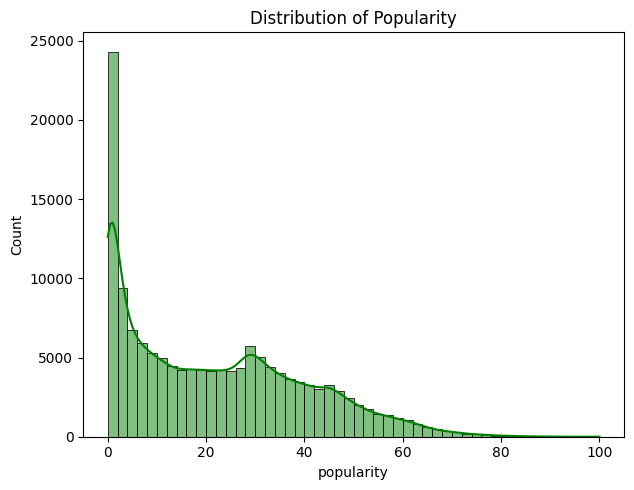

In [107]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.histplot(df['popularity'], bins=50, kde=True, color='green')
plt.title('Distribution of Popularity')

plt.tight_layout()
plt.show()

In [108]:
from sklearn.preprocessing import StandardScaler
# LEts perform the standard scaler as these 2 attributes are the in the order.
scaler = StandardScaler()
df[['followers', 'popularity']] = scaler.fit_transform(df[['followers', 'popularity']])

In [109]:
df.head(5)

,spotify_id,name,followers,popularity,alternative Indie,classical_orchestral,electronic,folk world,hazz,hip_hop,latin,metal,pop,randb_Soul,reggae_dancehall,rock,soundtrack,unknown
0,48WvrUGoijadXXCsGocwM4,Byklubben,-0.089629,0.138985,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1.977204,2.749886,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,652XIvIBNGg3C0KIGEJWit,Maxim,-0.055638,0.791710,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,0.166400,1.662010,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,-0.069503,0.954891,1,0,0,0,0,0,0,0,1,0,0,0,0,0


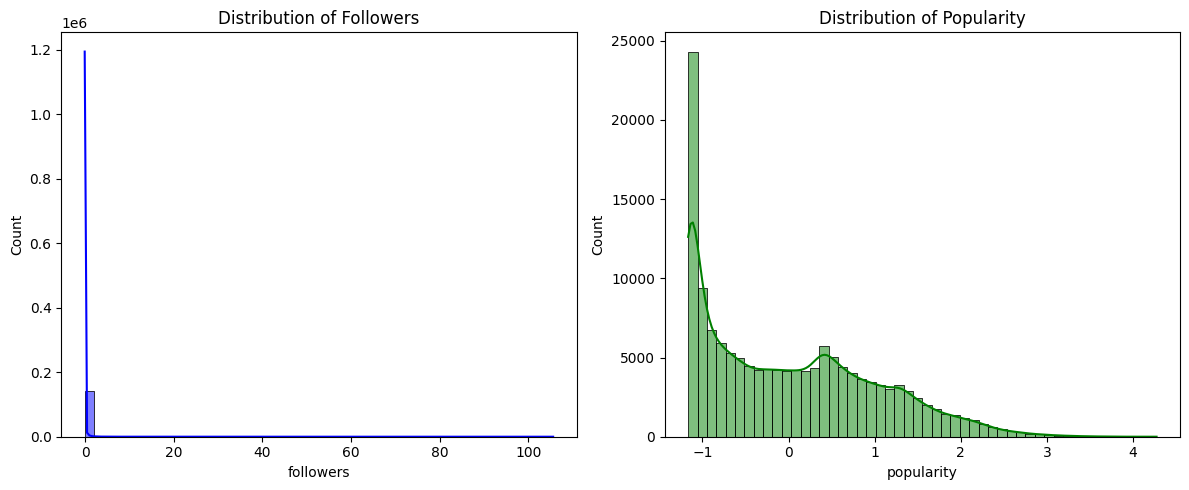

In [49]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['followers'], bins=50, kde=True, color='blue')
plt.title('Distribution of Followers')

plt.subplot(1, 2, 2)
sns.histplot(df['popularity'], bins=50, kde=True, color='green')
plt.title('Distribution of Popularity')

plt.tight_layout()
plt.show()

In [112]:
df.to_csv("nodes_cleaned.csv", index= False)

In [113]:
df_1 = pd.read_csv("nodes_cleaned.csv")

In [114]:
df_1.head()

,spotify_id,name,followers,popularity,alternative Indie,classical_orchestral,electronic,folk world,hazz,hip_hop,latin,metal,pop,randb_Soul,reggae_dancehall,rock,soundtrack,unknown
0,48WvrUGoijadXXCsGocwM4,Byklubben,-0.089629,0.138985,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1.977204,2.749886,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,652XIvIBNGg3C0KIGEJWit,Maxim,-0.055638,0.791710,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,0.166400,1.662010,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,-0.069503,0.954891,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [110]:
# Since spotify_id and names are our identifiers.

columns_to_include = ['followers', 'popularity', 'alternative Indie', 'classical_orchestral',
                      'electronic', 'folk world', 'hazz', 'hip_hop', 'latin', 'metal',
                      'pop', 'randb_Soul', 'reggae_dancehall', 'rock', 'soundtrack', 'unknown']

X = df[columns_to_include]